# Vehicle Road Bounding Box

This example shows how to place a road in BeamNG.tech, make a vehicle drive along a specified path, and continually query its current bounding box to test if it is on the road. For demonstration purposes the code will display plots of the relevant components in the scenario and an overhead view of the vehicle in the actual simulator. In summary, this code will show:

* Road placement in a scenario.
* Vehicle placement in a scenario.
* Defining a path for the vehicle to drive along using the [script AI](https://www.youtube.com/watch?v=11c2lUiPKqw).
* Attaching a camera sensor and rendering images from it.
* Obtaining a road's geometry from the simulation.
* Querying a vehicle's current bounding box.
* Stepping through the simulation.

## Setup

Besides third party libraries like Numpy for mathematical operations, Shapely for geometry, and so on, this example mainly relies on the `Scenario`, `Vehicle`, and `Road` classes from BeamNGpy. These allow defining a new scenario for the simulator and placing a vehicle & road inside it. To show the scenario playing out we also include the `Camera` sensor.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from beamngpy import BeamNGpy, Road, Scenario, Vehicle
from beamngpy.sensors import Camera
from shapely.geometry import Polygon

## Scenario Creation

The layout of our scenario is relatively simple as it only involves two key components: a road to drive along and a vehicle that drives including a camera attached to it.

Placing the road is done by first constructing a new instance of the `Road` class with certain properties we want the road to have. Namely, the texture the road has visually, the length of said texture to avoid nasty stretching, and a name for the road we will use to identify it later. The actual geometry of the road is defined a via list of nodes. Each node is a tuple of four values: The X, Y, Z values of the node and a width of the road at that node in meters. This format is easily visualized in the map editor the simulator ships with, where a road's nodes are highlighted with green dots and the width clearly shown using a horizontal line:

![DecalRoad nodes](https://github.com/BeamNG/BeamNGpy/raw/master/media/DecalRoadNodes.png)

**Note**: BeamNG.tech automatically interpolates nodes between the specified ones if the angle between them is too sharp so as to have smoother roads. In the image above, the horizontal lines without a green dot are such interpolated lines. This interpolation can be disabled by passing `interpolate=False` to the road's constructor, leaving control of the exact shape up to the user. Alternatively, the angle past which additional edges get interpolated can be changed by passing `break_angle=<angle>` to the constructor. For example, `Road(..., break_angle=30)` would create a road that only interpolates lines between nodes that change by more than 30 degrees.

After the road, we define a new vehicle of the `etk800` model that BeamNG.tech ships with and give it the name `ego_vehicle`. We attach a camera to this vehicle which floats 5 meters above, 10 meters behind it looking down onto the vehicle. Of course, a free floating camera like this is slightly unrealistic, but it's mainly for illustration purposes. We place the vehicle in the scenario at the start of the road by re-using the first node's position.

The last line `scenario.make(beamng)` is what actually assembles the files necessary for our scenario and places them where the simulator can find it once it is started.

In [2]:
beamng = BeamNGpy("localhost", 25252)
beamng.open()

scenario = Scenario("gridmap_v2", "vehicle_bbox_example")
road = Road("track_editor_C_center", rid="main_road", texture_length=5)
orig = (-107, 20, 100)
goal = (-300, 20, 100)
road.add_nodes((*orig, 7), (*goal, 7))
scenario.add_road(road)

vehicle = Vehicle("ego_vehicle", model="etk800", license="PYTHON")
scenario.add_vehicle(vehicle, pos=orig)
scenario.make(beamng)

beamng.settings.set_deterministic(60)

beamng.scenario.load(scenario)
beamng.scenario.start()

overhead = Camera(
    "overhead",
    beamng,
    vehicle,
    pos=(0, 10, 5),
    dir=(0, -1, -0.75),
    field_of_view_y=60,
    resolution=(1024, 1024),
)

## Running

The scenario has been started by the simulation. Note: the scenario simulation does not start immediately after loading, but only when the user triggers the start using `scenario.start()`.

## Getting Our Road's Data

Once the scenario is loaded, we move on to query the exact geometry of the road we placed. This is mainly done because, as described above, the simulator might smooth out transitions between nodes, so the final geometry of the road can vary slightly. In our case this would not happen, as we placed a completely straight road, but for demonstration purposes the code below still queries the simulator for our road's geometry using the name we gave the road at construction. The result we get is plotted to show we placed a straight road at the coordinates specified above.

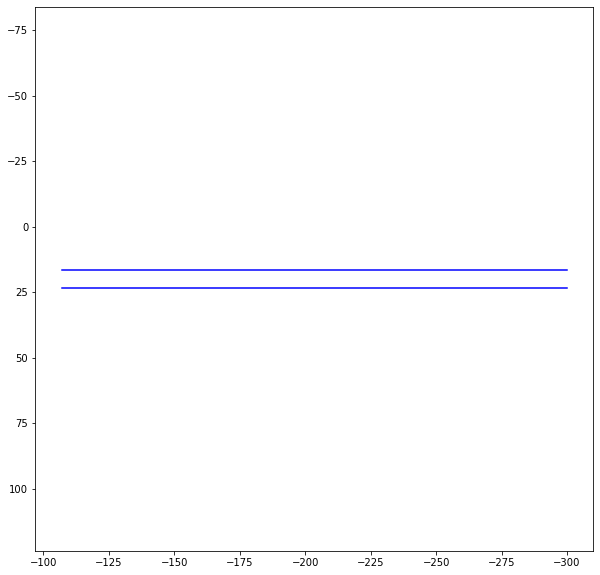

In [3]:
road_geometry = beamng.scenario.get_road_edges("main_road")
left_edge_x = np.array([e["left"][0] for e in road_geometry])
left_edge_y = np.array([e["left"][1] for e in road_geometry])
right_edge_x = np.array([e["right"][0] for e in road_geometry])
right_edge_y = np.array([e["right"][1] for e in road_geometry])


def plot_road(ax):
    x_min = (
        min(left_edge_x.min(), right_edge_x.min()) - 10
    )  # We add/subtract 10 from the min/max coordinates to pad
    x_max = (
        max(left_edge_x.max(), right_edge_x.max()) + 10
    )  # the area of the plot a bit
    y_min = min(left_edge_y.min(), right_edge_y.min()) - 10
    y_max = max(left_edge_y.max(), right_edge_y.max()) + 10
    ax.set_aspect("equal", "datalim")
    ax.set_xlim(
        left=x_max, right=x_min
    )  # pyplot & bng coordinate systems have different origins
    ax.set_ylim(bottom=y_max, top=y_min)  # so we flip them here
    ax.plot(left_edge_x, left_edge_y, "b-")
    ax.plot(right_edge_x, right_edge_y, "b-")


plt.figure(figsize=(10, 10))
plot_road(plt.gca())
plt.show()

## Computing a Path

To show how testing whether or not a vehicle is on the road or not can be performed using BeamNGpy, we want the vehicle to drive along a path that includes both periods where the vehicle is on the road and ones where it is not. Vehicles in BeamNG.tech ship with an AI that can be configured to drive along so-called "scripts." The term "script" is used because, in addition to a mere path to follow, the scripts also include timestamps that specify *when* a vehicle should be at what point. The AI follows this script by driving from point to point with the speed necessary (and feasible) to be there on time.

**Note**: There's no cheating with the AI. If the user specifies, for example, a 130 degree turn at 130km/h, the AI will not magically stop in place and turn around in an instant. The AI operates the vehicle using only the actuators a human driver would have (steering wheel, throttle, brake, etc.) and has to follow the same limitations. For the extreme example above, the AI would end up performing a hard brake, likely skidding away from the specified path, turning around when it can, and driving to the next point in the script.

For illustration purposes the curve we computed is also plotted on top of the road, showing we made a path for the AI that intersects and leaves the road at several points.

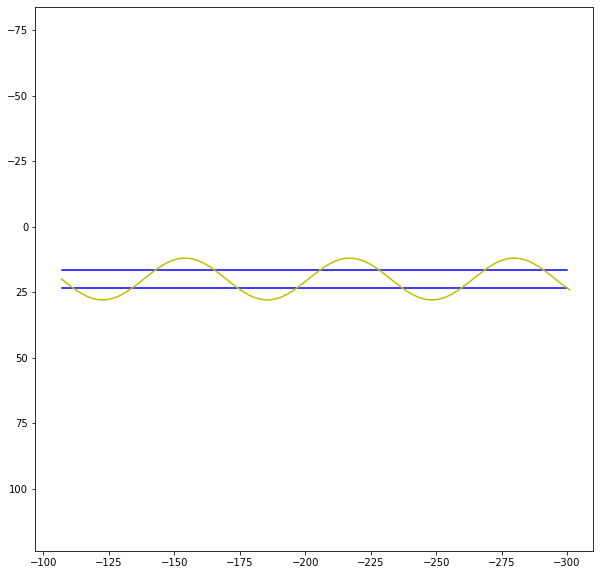

In [4]:
script = [{"x": orig[0], "y": orig[1], "z": orig[2], "t": 0}]
i = 0.2

while script[-1]["x"] > goal[0]:
    node = {
        "x": -10 * i + orig[0],
        "y": 8 * np.sin(i) + orig[1],
        "z": 100,
        "t": 1.5 * i,
    }
    script.append(node)
    i += 0.2

script_x = [s["x"] for s in script]
script_y = [s["y"] for s in script]


def plot_script(ax):
    ax.plot(script_x, script_y, "y-")


plt.figure(figsize=(10, 10))
plot_road(plt.gca())
plot_script(plt.gca())
plt.show()

## Starting the AI Script

Each instance of the `Vehicle` class has various `ai_*` methods exposing the simulator's AI to the user. For scripts, the corresponding method is `ai_set_script(<script>)` which we call using the script computed above. The most noteworthy thing about this code block is what happens after: We pause the simulation and advance it for a single frame. Pausing is done for a simple reason: The vehicle would immediately start driving along the script we gave it and, in this example, we want to wait a bit before it does so. Advancing the simulation for a single frame is done because starting a script moves the vehicle to the first point in the script facing the next one, so we advance one frame giving the simulator the opportunity to move the vehicle.

In [5]:
vehicle.ai.set_script(script)
beamng.control.pause()
beamng.control.step(1)

## Road & Vehicle Bounding Boxes

Vehicles in BeamNG.tech provide information about their current bounding box. This box is the smallest cuboid that contains all of the vehicle's geometry and can be used to perform tests that rely on more than the mere position of a vehicle. Said bounding box can be obtained using the `vehicle.get_bbox()` method. This returns a dictionary of eight points that make up the cuboid containing the vehicle. In our test we're mainly interested in the points of the vehicle on the ground, so the focus is on the bottom points of the bounding box.

**Note**: One limitation of this method is that the volume of the bounding box does not change to account for vehicle deformations and only describes the vehicle at spawn time. The position and rotation updates along with the vehicle, but if, for example, a vehicle crashes into a wall at such speed that it gets flattened, the resulting change in volume is not reflected in the bounding box — only the respective change in position & orientation.

With the vehicle's bounding box and the road's geometry known, we can use the very helpful [Shapely](https://shapely.readthedocs.io/en/stable/manual.html) library to construct instances of the `Polygon` class that perform geometrical comparisons for us. The `road_poly` and `bbox_poly` variables contain polygons for road and the bottom rectangle of the bounding box respectively and are used to do intersection tests. This test is implemented in the `inbounds` function. As a simple heuristic, this function does not test if the bounding box is fully contained in the road, but instead computes the intersecting area using Shapely and considers a vehicle within the road if more than 50% of its bounding box's area is contained in the road.

This function is then used during plotting to change the color of the vehicle depending on whether or not it is on the road: Green when it is inside, red when it is outside.

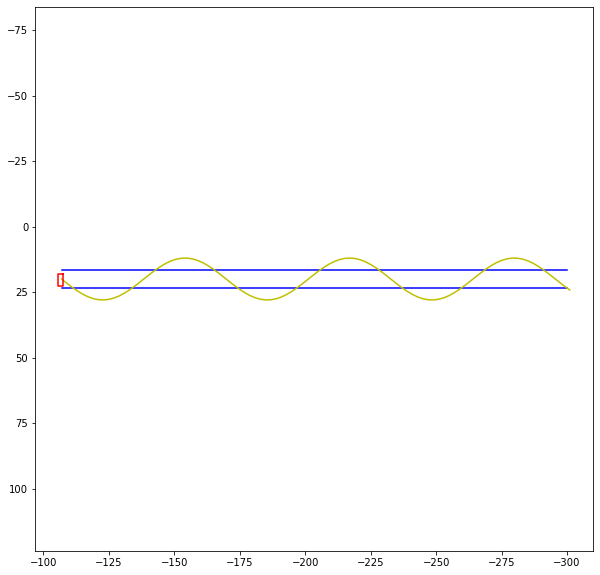

In [6]:
road_poly = list(zip(left_edge_x, left_edge_y))
road_poly.extend(zip(right_edge_x[::-1], right_edge_y[::-1]))
road_poly = Polygon(road_poly)


def inbounds(bbox_x, bbox_y):
    bbox_poly = zip(bbox_x, bbox_y)
    bbox_poly = Polygon(bbox_poly)
    inter = bbox_poly.intersection(road_poly)
    return inter.area / bbox_poly.area > 0.5


def plot_bbox(ax):
    bbox = vehicle.get_bbox()
    boundary_x = [
        bbox["front_bottom_left"][0],
        bbox["front_bottom_right"][0],
        bbox["rear_bottom_right"][0],
        bbox["rear_bottom_left"][0],
        bbox["front_bottom_left"][0],
    ]
    boundary_y = [
        bbox["front_bottom_left"][1],
        bbox["front_bottom_right"][1],
        bbox["rear_bottom_right"][1],
        bbox["rear_bottom_left"][1],
        bbox["front_bottom_left"][1],
    ]
    if inbounds(boundary_x, boundary_y):
        ax.plot(boundary_x, boundary_y, "g-")
    else:
        ax.plot(boundary_x, boundary_y, "r-")


plt.figure(figsize=(10, 10))
plot_road(plt.gca())
plot_script(plt.gca())
plot_bbox(plt.gca())
plt.show()

## Overhead View

For additional illustration, this example attached a camera floating behind the vehicle. This is only there to show the example playing out and demonstrate the vehicle's bounding box and road in the plots matching the simulation. The view from the camera is obtained by polling all sensors on a vehicle using `vehicle.sensors.poll()` and plotting the resulting image.

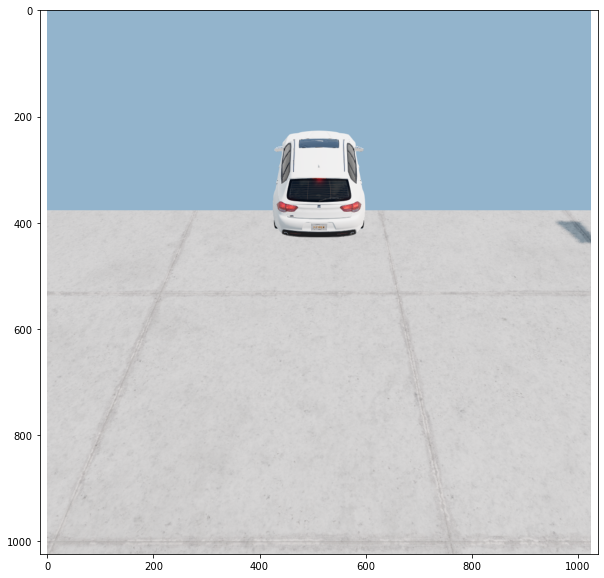

In [7]:
def plot_overhead(ax):
    camera_data = overhead.poll()
    view = camera_data["colour"]
    view = view.convert("RGB")  # Drop alpha channel as it messes up the plot
    ax.imshow(np.asarray(view))
    ax.set_aspect("equal", "datalim")


plt.figure(figsize=(10, 10))
plot_overhead(plt.gca())
plt.show()
plt.clf()
plt.close()

## Putting it All Together

Now that the scenario is created, a path for the AI computed, and a function to test vehicle bounds is implemented, we move on to let the vehicle drive along the path while regularly sampling its bounding box and testing whether or not it is on the road. The code below is doing this in a loop of twenty steps: In each step we advance the simulation by 200 frames, thus making the vehicle follow the path for just above three seconds between each sample. Afterwards, the current road, path, bounding box, and overhead view are plotted. Whether the vehicle is within the road or not is indicated by its color.

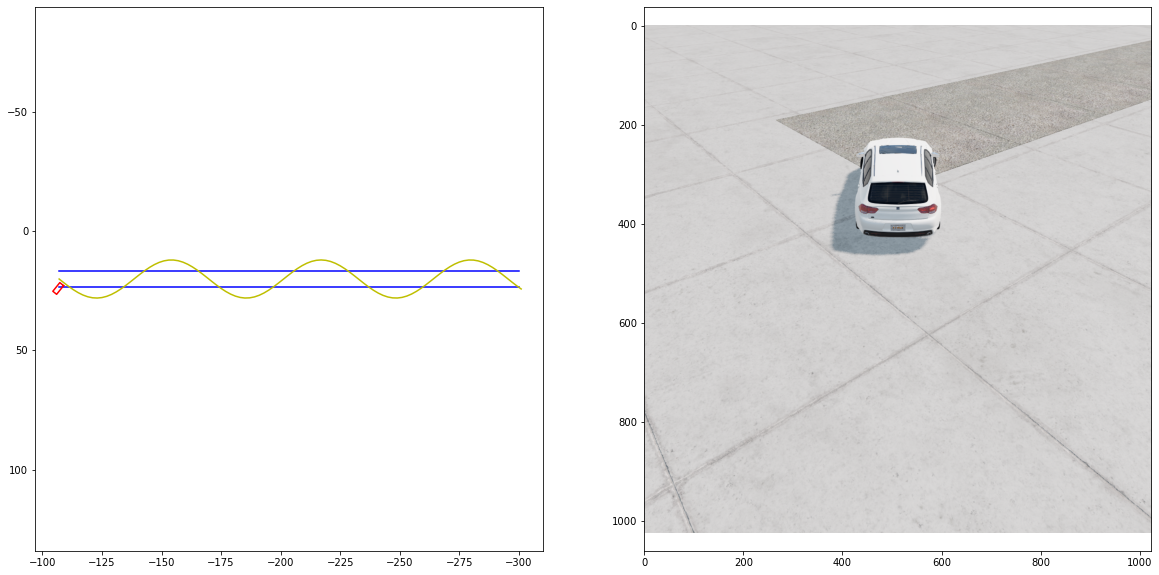

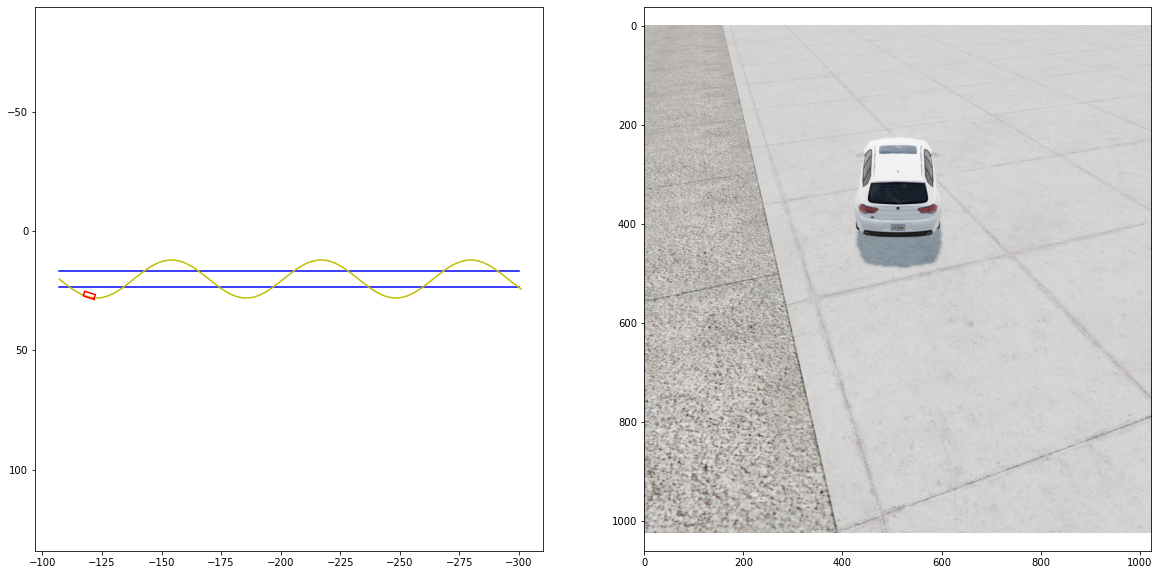

BNGDisconnectedError: The simulator ended the connection.

In [8]:
for row in range(10):
    beamng.control.step(200)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    plot_road(ax[0])
    plot_script(ax[0])
    plot_bbox(ax[0])
    plot_overhead(ax[1])
    plt.show()

# Conclusion

This example has shown a simple case of tracking a vehicle's bounding box while driving along a road and comparing that box to the road's surface. Several concepts and functions of the BeamNGpy libraries were explained alongside illustrative plots and renders of the simulation. It should be clear how this example case can be extended to more sophisticated scenarios.